## Run this notebook

You can launch this notebook in the US GHG Center JupyterHub by clicking the link below.

[Launch in the US GHG Center JupyterHub (requires access)](https://hub.ghg.center/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FUS-GHG-Center%2Fghgc-docs&urlpath=lab%2Ftree%2Fghgc-docs%2Fuser_data_notebooks%2Fcasagfed-carbonflux-monthgrid-v3_User_Notebook.ipynb&branch=main)
   

## Approach

1. Identify available dates and temporal frequency of observations for a given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Land-Atmosphere Carbon Flux data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.
   

## About the Data
#### CASA-GFED3

This dataset presents a variety of carbon flux parameters derived from the Carnegie-Ames-Stanford-Approach – Global Fire Emissions Database version 3 (CASA-GFED3) model. The model’s input data includes air temperature, precipitation, incident solar radiation, a soil classification map, and a number of satellite derived products. All model calculations are driven by analyzed meteorological data from NASA’s Modern-Era Retrospective analysis for Research and Application, Version 2 (MERRA-2). The resulting product provides monthly, global data at 0.5 degree resolution from January 2003 through December 2017. It includes the following carbon flux variables expressed in units of kilograms of carbon per square meter per month (kg Carbon m²/mon) from the following sources: net primary production (NPP), net ecosystem exchange (NEE), heterotrophic respiration (Rh), wildfire emissions (FIRE), and fuel wood burning emissions (FUEL). This product and earlier versions of MERRA-driven CASA-GFED carbon fluxes have been used in a number of atmospheric CO₂ transport studies, and through the support of NASA’s Carbon Monitoring System (CMS), it helps characterize, quantify, understand and predict the evolution of global carbon sources and sinks.

## STAC Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. CASA-GFED3
- `item`:       One granule in the dataset, e.g. one monthly file of carbon fluxes
- `asset`:      A variable available within the granule, e.g. NPP, NEE, Rh
- `STAC API`:   Endpoint for fetching the data itself
- `Raster API`: Endpoint for fetching data **imagery**

# Installing the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests, folium, rasterstats, pystac_client, pandas, matplotlib

In [2]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt
import ghgc_utils

## Querying the STAC API
Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the CASA-GFED Land-Atmosphere Carbon Flux dataset is [**casagfed-carbonflux-monthgrid-v3**](https://earth.gov/ghgcenter/api/stac/collections/casagfed-carbonflux-monthgrid-v3).*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [3]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in the STAC collection.
# Name of the collection for CASA GFED Land-Atmosphere Carbon Flux monthly emissions. 
collection_name = "casagfed-carbonflux-monthgrid-v3"

In [4]:
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)
collection


<CollectionClient id=casagfed-carbonflux-monthgrid-v3>

In [5]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 180 items


In [6]:
search = catalog.search(
    collections=collection_name,
    datetime=['2010-01-01T00:00:00Z','2010-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)
   

<Item id=casagfed-carbonflux-monthgrid-v3-201012>
<Item id=casagfed-carbonflux-monthgrid-v3-201011>
<Item id=casagfed-carbonflux-monthgrid-v3-201010>
<Item id=casagfed-carbonflux-monthgrid-v3-201009>
<Item id=casagfed-carbonflux-monthgrid-v3-201008>
<Item id=casagfed-carbonflux-monthgrid-v3-201007>
<Item id=casagfed-carbonflux-monthgrid-v3-201006>
<Item id=casagfed-carbonflux-monthgrid-v3-201005>
<Item id=casagfed-carbonflux-monthgrid-v3-201004>
<Item id=casagfed-carbonflux-monthgrid-v3-201003>
<Item id=casagfed-carbonflux-monthgrid-v3-201002>
<Item id=casagfed-carbonflux-monthgrid-v3-201001>


Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2003 to December 2017. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [7]:
# Examine the first item in the collection
items[0]

<Item id=casagfed-carbonflux-monthgrid-v3-201712>

In [12]:
#  Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# 'npp' = net primary production
asset_name = "npp"

# Creating Maps using Folium
We will explore changes in the land atmosphere Carbon flux Net Primary Productivity and examine its impacts over time. We'll then visualize the outputs on a map using `folium`. 

## Fetch Imagery Using the Raster API
Here we get information from the Raster API which we will add to our map in the next section.

In [7]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items_dict = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

In [8]:
# Choose a color for displaying the data
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "viridis"

In [9]:
# Specify which two date/times you would like to visualize, using the format of items_dict.keys()
dates = ["2010-01","2003-01"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [11]:
# Extract collection name and item ID for the first date
first_date = items_dict[dates[0]]
collection_id = first_date.collection_id
item_id = first_date.id
# Select relevant asset (NPP)
object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print the raster bands' information
raster_bands 

[{'scale': 1.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float32',
  'histogram': {'max': 0.23026999831199646,
   'min': 0.0,
   'count': 11.0,
   'buckets': [244259.0,
    3221.0,
    2076.0,
    2056.0,
    3230.0,
    3103.0,
    996.0,
    195.0,
    53.0,
    11.0]},
  'statistics': {'mean': 0.00534185953438282,
   'stddev': 0.022541318088769913,
   'maximum': 0.23026999831199646,
   'minimum': 0.0,
   'valid_percent': 0.0003858024691358025}}]

In [12]:
# Use mean, scaled stddev, and minimum to generate an appropriate color bar range.
rescale_values = {
    #"max": raster_bands[0]['statistics']['mean'] + 4*raster_bands[0]['statistics']['stddev'],
    "max": raster_bands[0]['statistics']['maximum'],
    "min": raster_bands[0]['statistics']['minimum'],
}

print(rescale_values)

{'max': 0.23026999831199646, 'min': 0.0}


In [13]:
# Make a GET request to retrieve information for your first date/time
date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
date_1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/casagfed-carbonflux-monthgrid-v3/items/casagfed-carbonflux-monthgrid-v3-201001/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=0.0%2C0.23026999831199646'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [14]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile, because we dates tiles 1 and 2 to have the same colorbar range for best visual comparison.
second_date = items_dict[dates[1]]
# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id


date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

date_2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/casagfed-carbonflux-monthgrid-v3/items/casagfed-carbonflux-monthgrid-v3-200301/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=0.0%2C0.23026999831199646'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Generate Map
First, we'll define the Area of Interest (AOI) as a GEOJSON. This will be visualized as a filled polygon on the map.

In [15]:
# The AOI is currently set to the Amazon rainforest in South America
aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-74.0, -3.0],   # Southwest Bounding Coordinate
                [-74.0, 5.0],    # Southeast Bounding Coordinate
                [-60.0, 5.0],    # Northeast Bounding Coordinate
                [-60.0, -3.0],   # Northwest Bounding Coordinate
                [-74.0, -3.0]    # Closing the polygon at the Southwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


In [16]:
# For this study we are going to compare the NPP level in 2003 and 2017
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement
# For example, you can change the current statement "location=(0, -66)" to "location=(34, -118)" to monitor the NPP level in California instead of Amazon Basin

# Set initial zoom and center of map for CO₂ Layer
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(0, -66), zoom_start=5)

# The TileLayer library helps in manipulating and displaying raster layers on a map
# December 2003
map_layer_1 = TileLayer(
    tiles=date_1_tile["tiles"][0],
    attr="GHG",
    opacity=0.8,
    name=f"{dates[0]} NPP",
    overlay= True,
    legendEnabled = True
)
map_layer_1.add_to(map_.m1)


# December 2017
map_layer_2 = TileLayer(
    tiles=date_2_tile["tiles"][0],
    attr="GHG",
    opacity=0.8,
    name=f"{dates[1]} NPP",
    overlay= True,
    legendEnabled = True
)
map_layer_2.add_to(map_.m2)


# Display data markers (titles) on both maps
folium.Marker((0, -66), tooltip="Amazon Rainforest").add_to(map_)
folium.GeoJson(aoi, name="Amazon Rainforest, South America",
        style_function=lambda feature: {
        "fillColor": "none",
    }).add_to(map_)
folium.LayerControl(collapsed=False).add_to(map_)


# Add a colorbar
# For this, use one of our custom 'ghgc_utils' functions to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(
                color_map,
                rescale_values,
                label='NPP Values (kg Carbon/m2/month)'
    )

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualizing the map
map_

# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this case we are focusing on an Area of Interest (AOI) in the Amazon Rainforest, South America.

In [13]:
# Give the AOI a name to be used in your time series plot later on.
aoi_name = 'Amazon Rainforest'
# The AOI is defined as a GEOJSON
aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-74.0, -3.0],   # Southwest Bounding Coordinate
                [-74.0, 5.0],    # Southeast Bounding Coordinate
                [-60.0, 5.0],    # Northeast Bounding Coordinate
                [-60.0, -3.0],   # Northwest Bounding Coordinate
                [-74.0, -3.0]    # Closing the polygon at the Southwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


In [14]:
# Check the total number of items available for this location
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

print(f"Found {len(items)} items")

Found 180 items


In [15]:
# Explore the first item
items[0]

{'id': 'casagfed-carbonflux-monthgrid-v3-201712',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/casagfed-carbonflux-monthgrid-v3'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/casagfed-carbonflux-monthgrid-v3'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/casagfed-carbonflux-monthgrid-v3/items/casagfed-carbonflux-monthgrid-v3-201712'}],
 'assets': {'rh': {'href': 's3://ghgc-data-store/casagfed-carbonflux-monthgrid-v3/GEOSCarb_CASAGFED3v3_Rh_Flux_Monthly_x720_y360_201712.tif',
   'type': 'image/tiff; application=geotiff',
   'roles': ['data', 'layer'],
   'title': 'Heterotrophic Respiration (Rh)',
   'proj:bbox': [-

In [16]:
# Use one of the custom 'ghgc_utils' functions to generate statistics over your AOI using the Raster API
# This step may take a minute.
df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)
# Print the first 5 lines of our statistics
df.head(5)

Generating stats...
Done!


,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2017-12-01T00:00:00+00:00,0.00000000000000000000,0.14889000356197357178,0.10258256644010543823,448.00000000000000000000,45.95698928833007812500,0.01967255024739580915,0.10275000333786010742,0.09723000228404998779,0.02135000005364418030,428.00000000000000000000,"[[2, 4, 4, 4, 12, 32, 180, 129, 67, 14], [0.0,...",100.00000000000000000000,0.00000000000000000000,448.00000000000000000000,0.03991999849677085876,0.13566000759601593018,2017-12-01 00:00:00+00:00
1,2017-11-01T00:00:00+00:00,0.00000000000000000000,0.14427000284194946289,0.09407528489828109741,448.00000000000000000000,42.14572906494140625000,0.02026101247157912136,0.09871999919414520264,0.09173000603914260864,0.02068000100553035736,416.00000000000000000000,"[[2, 4, 5, 3, 59, 47, 144, 147, 25, 12], [0.0,...",100.00000000000000000000,0.00000000000000000000,448.00000000000000000000,0.03833000361919403076,0.13496001064777374268,2017-11-01 00:00:00+00:00
2,2017-10-01T00:00:00+00:00,0.00000000000000000000,0.14732000231742858887,0.10603155195713043213,448.00000000000000000000,47.50213623046875000000,0.02224919948257916141,0.11008000373840332031,0.00000000000000000000,0.02546999976038932800,432.00000000000000000000,"[[2, 3, 2, 5, 35, 39, 56, 141, 148, 17], [0.0,...",100.00000000000000000000,0.00000000000000000000,448.00000000000000000000,0.05106000229716300964,0.13716000318527221680,2017-10-01 00:00:00+00:00
3,2017-09-01T00:00:00+00:00,0.00000000000000000000,0.14823000133037567139,0.10667276382446289062,448.00000000000000000000,47.78939819335937500000,0.01710272201593139585,0.10791999846696853638,0.10473000258207321167,0.04506000131368637085,415.00000000000000000000,"[[2, 0, 0, 5, 13, 39, 72, 225, 80, 12], [0.0, ...",100.00000000000000000000,0.00000000000000000000,448.00000000000000000000,0.06181000173091888428,0.13686999678611755371,2017-09-01 00:00:00+00:00
4,2017-08-01T00:00:00+00:00,0.00000000000000000000,0.16002999246120452881,0.11495316773653030396,448.00000000000000000000,51.49901962280273437500,0.01792853090793348689,0.11591000109910964966,0.10767000168561935425,0.04944000020623207092,414.00000000000000000000,"[[2, 0, 0, 5, 11, 24, 109, 225, 51, 21], [0.0,...",100.00000000000000000000,0.00000000000000000000,448.00000000000000000000,0.06682000309228897095,0.15235000848770141602,2017-08-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the NPP time series for the Amazon Rainforest, South America area. We can plot the data set using the code below:

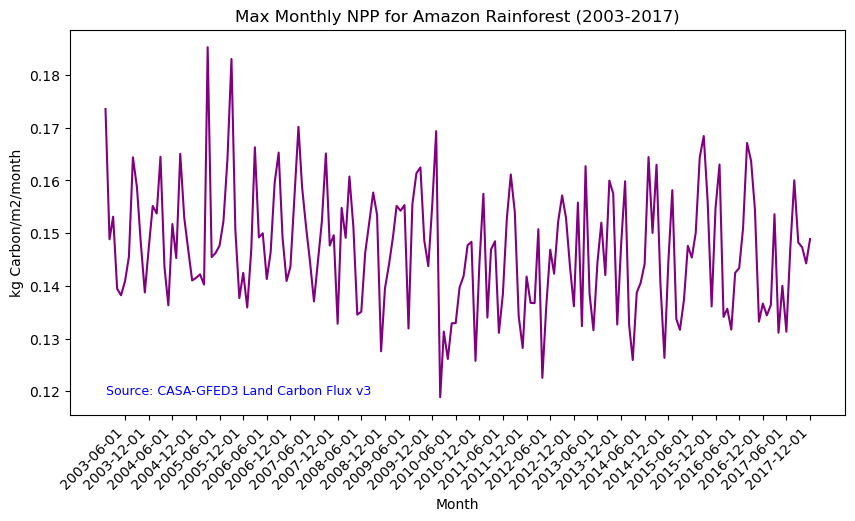

In [28]:
# Plot data
fig = plt.figure(figsize=(10,5))  # Set the size of the figure

# Change "which_stat" if you would rather look at something like mean, median, or standard deviation.
which_stat = 'max'

plt.plot(
    df["date"][:],
    df[which_stat],
    color="purple",
    linestyle="-",
    linewidth=1.5,
)

# Add x labels at desired positions (for example, every 6 months)
plt.xticks(
    df["date"][::6],  
    rotation=45,  # Rotate labels to avoid overlap
    ha="right"
)

# Labels and title
plt.xlabel("Month")
plt.ylabel("kg Carbon/m2/month")
plt.title(f"{which_stat.capitalize()} Monthly {asset_name.upper()} for {aoi_name} (2003-2017)")

# Add data citation
plt.text(
    df["date"][:].min(),                         # X-coordinate of the text (first datetime value)
    df[which_stat].min(),                  # Y-coordinate of the text (minimum CO2 value)

    # Text to be displayed
    f"Source: {collection.title}",                   
    fontsize=9,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="bottom",              # Vertical alignment
    color="blue",                            # Text color
)

plt.show()

In [20]:
[d[0:7] for d in df["datetime"][:]]

['2017-12',
 '2017-11',
 '2017-10',
 '2017-09',
 '2017-08',
 '2017-07',
 '2017-06',
 '2017-05',
 '2017-04',
 '2017-03',
 '2017-02',
 '2017-01',
 '2016-12',
 '2016-11',
 '2016-10',
 '2016-09',
 '2016-08',
 '2016-07',
 '2016-06',
 '2016-05',
 '2016-04',
 '2016-03',
 '2016-02',
 '2016-01',
 '2015-12',
 '2015-11',
 '2015-10',
 '2015-09',
 '2015-08',
 '2015-07',
 '2015-06',
 '2015-05',
 '2015-04',
 '2015-03',
 '2015-02',
 '2015-01',
 '2014-12',
 '2014-11',
 '2014-10',
 '2014-09',
 '2014-08',
 '2014-07',
 '2014-06',
 '2014-05',
 '2014-04',
 '2014-03',
 '2014-02',
 '2014-01',
 '2013-12',
 '2013-11',
 '2013-10',
 '2013-09',
 '2013-08',
 '2013-07',
 '2013-06',
 '2013-05',
 '2013-04',
 '2013-03',
 '2013-02',
 '2013-01',
 '2012-12',
 '2012-11',
 '2012-10',
 '2012-09',
 '2012-08',
 '2012-07',
 '2012-06',
 '2012-05',
 '2012-04',
 '2012-03',
 '2012-02',
 '2012-01',
 '2011-12',
 '2011-11',
 '2011-10',
 '2011-09',
 '2011-08',
 '2011-07',
 '2011-06',
 '2011-05',
 '2011-04',
 '2011-03',
 '2011-02',
 '20

In [56]:
# Fetch the third granule in the collection and set the color scheme and rescale values. 
n = 2
october_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items[n]['collection']}/items/{items[n]['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/casagfed-carbonflux-monthgrid-v3/items/casagfed-carbonflux-monthgrid-v3-201710/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=0.0%2C0.23026999831199646'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [57]:
# Map the NPP level for the Congo area for the chosen tile
aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        1, # latitude
        17, # longitude
    ],
    zoom_start=5,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.7, name=f"{items[n]['properties']['start_datetime'][0:7]} {asset_name}", overlay= True, legendEnabled = True
)

map_layer.add_to(aoi_map_bbox)

# Display data marker (title) on the map
folium.Marker((1,17), tooltip="Dallas").add_to(aoi_map_bbox)
folium.LayerControl(collapsed=False).add_to(aoi_map_bbox)

# Add a legend
colormap = branca.colormap.linear.viridis.scale(rescale_values['min'],rescale_values['max']) # minimum value = 0, maximum value = 0.3 (kg Carbon/m2/month)
#colormap = colormap.to_step(index=[0, 0.07, 0.15, 0.22, 0.3])
colormap.caption = 'NPP (kg Carbon/m2/month)'

colormap.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for CASA GFED Land-Atmosphere Carbon Flux data:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the Net Primary Production (NPP) levels over the Amazon Rainforest, South America area for two distinctive years
5.	Create a table that displays the minimum, maximum, and sum of the NPP values for a specified region
6.	Generate a time-series graph of the NPP values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 